# Training loop for UNet with SE and res blocks
First training step is on patches of 512x512 cxrs, patch sizes should be 64x64.

## Flexible setup
This NB is designed to work flawlessly with either Google Colab or on a local machine.

In [ ]:
# Colab setup
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("IN_COLAB=", IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive/")
    os.chdir('/content/drive/MyDrive/Denoise/cxr-denoise/training')
    !pip install -r ../requirements.txt -q
    print("Requirements installed!")

IN_COLAB= False


In [ ]:
# Enviorment setup
import os
import torch
import numpy as np
import random

# Seeding
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# TODO (optional): fix xpu support
print("Using:", device)


Using: cpu


In [ ]:
# Get dataset from drive in colab - else sets DATA_PATH
# expect <5 min for 512², or <20 for 1024²
if IN_COLAB:
    import zipfile

    ZIP_PATH = "/content/drive/MyDrive/Datasets/NIH_data_512.zip"
    UNZIP_PATH = "/content/data/NIH_data_512"

    if not os.path.exists(UNZIP_PATH):
        os.makedirs(UNZIP_PATH, exist_ok=True)
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(UNZIP_PATH)
    DATA_PATH = "/content/data/NIH_data_512/content/NIH_data_512/" # TODO: fix redundent "content" - likely mistake in zipping
else:
    DATA_PATH = "../data/NIH_data_512"

## Dataset and Noise model setup
Sets up the splits for the diffrent NIH datasets

In [ ]:
# Load NIH Dataset
from nih_dataset import NIH_Dataset, RandomPatchDataset
from torch.utils.data import DataLoader
from noise import PreprocessClean, ApplyNoise
import torch
from PIL import Image
from torchvision import transforms

PRELOAD_TO_RAM = IN_COLAB

if not ('already_in_ram' in globals() or 'already_in_ram' in locals()): # dirty check to avoid reloading to ram
    nih_train = NIH_Dataset(DATA_PATH, split="train", preload_to_ram=PRELOAD_TO_RAM)
    nih_val = NIH_Dataset(DATA_PATH, split="val", preload_to_ram=PRELOAD_TO_RAM)
    nih_test = NIH_Dataset(DATA_PATH, split="test", preload_to_ram=PRELOAD_TO_RAM)

already_in_ram = PRELOAD_TO_RAM

NIH CXR Dataset (512x512), split='train' loaded with 69791 samples
NIH CXR Dataset (512x512), split='val' loaded with 16733 samples
NIH CXR Dataset (512x512), split='test' loaded with 25596 samples


In [ ]:
# Create Dataloaders and Patch dataset

#LIMIT_DATA = None # For Using Full Dataset
LIMIT_DATA = [320, 100, 100] # For Testing
BATCH_SIZE = 4
PATCH_BATCH_SIZE = 256
PATCH_SIZE = 64

if LIMIT_DATA:
    nih_train = torch.utils.data.Subset(nih_train, range(LIMIT_DATA[0])) if LIMIT_DATA[0] else nih_train
    nih_val = torch.utils.data.Subset(nih_val, range(LIMIT_DATA[1])) if LIMIT_DATA[1] else nih_val
    nih_test = torch.utils.data.Subset(nih_test, range(LIMIT_DATA[2])) if LIMIT_DATA[2] else nih_test



train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)



patch_train_dl = DataLoader(RandomPatchDataset(nih_train, PATCH_SIZE), batch_size=PATCH_BATCH_SIZE, pin_memory=True, num_workers=4)

print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")


train/val/test: 320/100/100


Sample batch shape: torch.Size([4, 1, 512, 512])


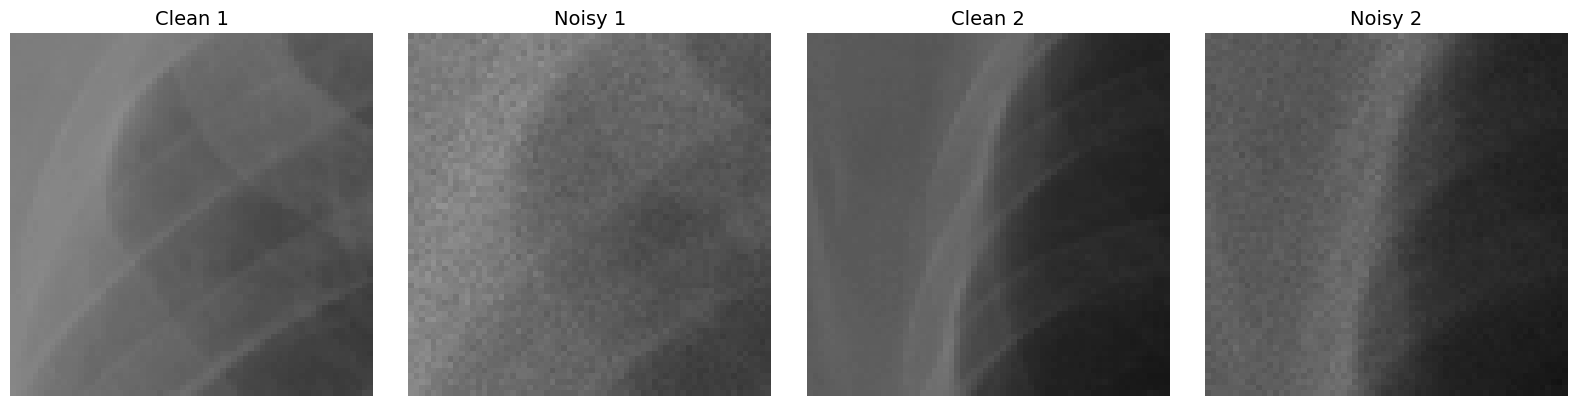

In [6]:
# Noise model
preproc: PreprocessClean = PreprocessClean() # apply to clean images for ground truth
noiser: ApplyNoise = ApplyNoise(blur_sigma=1.0) # apply to preproc to get noisy features

sample = next(iter(train_dl))
print("Sample batch shape:", sample[0].shape)

# Load and transform images named example_01.png to example_06.png
example_transf = transforms.ToTensor()
example_patches = [
    example_transf(Image.open(f"examples/patch_{i:02d}.png").convert("L")) for i in range(1, 7)
]

# Example Patches
example_patch_batch = torch.stack(example_patches).to(device)  # shape: (6, 1, H, W)
import cxr_plt

example_clean = preproc(example_patch_batch)
example_noisy = noiser(example_clean)

cxr_plt.plot_cxr_images(
    [example_clean[0], example_noisy[0], example_clean[1], example_noisy[1]], 
    ["Clean 1", "Noisy 1", "Clean 2", "Noisy 2"], figsize=(4*4, 4))


## Model and training

In [ ]:
# Model
from unet_model import ResUNetSE
import torchsummary
import torchinfo
import torch

BASE_CHANNELS = 32
model = ResUNetSE(features=BASE_CHANNELS, se_reduction=16).to(device=device)

with torch.no_grad():
    out = model(torch.zeros((1, 1, 512, 512)).to(device))
    print("model output shape:", out.shape)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

c:\Users\Morris\Workspace\cxr-denoise\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model output shape: torch.Size([1, 1, 512, 512])
Trainable parameters: 8,169,711


In [ ]:
# Training loop - patch training

import torch
from cxr_plt import *
from tqdm import tqdm
from loss import CombinedLoss, SpatialLoss, FrequencyLoss
import matplotlib.pyplot as plt
import os
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

from torchmetrics.functional import structural_similarity_index_measure as ssim
import torch.nn.functional as F
from train_util import *
import csv

criterion = CombinedLoss(mse_weight=1.0, l1_weight=0.5, freq_weight=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()

num_epochs = 10
patch_size = 64


metrics_log_path = "checkpoints/training_metrics.csv"
os.makedirs("checkpoints", exist_ok=True)

# Create CSV file with header if not exists
if not os.path.exists(metrics_log_path):
    with open(metrics_log_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "val_psnr", "val_ssim", "val_l1", "train_psnr", "train_ssim", "train_l1"])


total_batches = 0
for epoch in range(num_epochs):
    total_loss = 0.0
    total_freq_loss = 0.0
    total_mse_loss = 0.0
    total_l1_loss = 0.0
    pbar = tqdm(patch_train_dl, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in pbar:
        batch = batch[0] if isinstance(batch, (tuple, list)) else batch
        clean = batch.to(device)  # (B, 1, H, W)

        # Preprocess and noise
        clean = preproc(clean)

        # Apply noise
        noisy = noiser(clean)

        # Forward pass
        output = model(noisy)
        loss = criterion(output, clean)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_batches += 1

        total_loss += loss.item()
        
        component_losses = criterion.get_last_losses()
        if component_losses:
            total_freq_loss += component_losses['freq_loss']
            total_mse_loss += component_losses['mse_loss']
            total_l1_loss += component_losses['l1_loss']


        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(patch_train_dl)
    avg_freq_loss = total_freq_loss / len(patch_train_dl)
    avg_mse_loss = total_mse_loss / len(patch_train_dl)
    avg_l1_loss = total_l1_loss / len(patch_train_dl)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    print(f"  freq: {avg_freq_loss:.4f}, mse: {avg_mse_loss:.4f}, l1: {avg_l1_loss:.4f} (unweighted)")


    # Log visuals and metrics after each epoch
    with torch.no_grad():
        model.eval()

        clean = preproc(example_patch_batch.to(device))
        noisy = noiser(clean)
        output = model(noisy)

        save_cxr_triplet(clean, noisy, output, f"example_patches_epoch_{epoch}.png")

        val_metrics = evaluate_metrics_on_dataloader(model, val_dl, preproc, noiser, device, max_batches=500)
        train_metrics = evaluate_metrics_on_dataloader(model, train_dl, preproc, noiser, device, max_batches=500)

        # Save model checkpoint
        torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch+1}.pt")

        # Write metrics to CSV
        with open(metrics_log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                val_metrics["psnr"],
                val_metrics["ssim"],
                val_metrics["l1"],
                train_metrics["psnr"],
                train_metrics["ssim"],
                train_metrics["l1"]
            ])

        
        model.train()





Epoch 1/10: 100%|██████████| 2/2 [00:18<00:00,  9.28s/it, loss=2.0145]


Epoch 1 Average Loss: 3.4397
  freq: 10.14579153060913, mse: 0.21521098539233208, l1: 0.36159318685531616 (unweighted)


Epoch 2/10: 100%|██████████| 2/2 [00:18<00:00,  9.11s/it, loss=0.7841]


Epoch 2 Average Loss: 0.9132
  freq: 2.4266669750213623, mse: 0.07165158912539482, l1: 0.2270027920603752 (unweighted)


## Save and Eval

In [ ]:
test_metrics = evaluate_metrics_on_dataloader(model, test_dl, preproc, noiser, device, max_batches=None)

print("== Metrics on Test data ==")
print(f"PSNR: {test_metrics['psnr']}")
print(f"SSIM: {test_metrics['ssim']}")
print(f"L1:   {test_metrics['l1']}")


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cxr_plt

import torch.nn.functional as F
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import peak_signal_noise_ratio as psnr


image_path = "examples/fatpanel-binned-log.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_tensor = T.ToTensor()

model.eval()

fatpanel_cxr = Image.open(image_path).convert("L")
fatpanel_cxr = to_tensor(fatpanel_cxr)
fatpanel_cxr = fatpanel_cxr.unsqueeze(0).to(device)

print("Image shape:", fatpanel_cxr.shape)

with torch.no_grad():
    fatpanel_cxr_restored = model(fatpanel_cxr).clip(0.0,1.0)


# --- Metrics ---
l1 = F.l1_loss(fatpanel_cxr_restored, fatpanel_cxr).item()
psnr_val = psnr(fatpanel_cxr_restored, fatpanel_cxr, data_range=1.0).item()
ssim_val = ssim(fatpanel_cxr_restored, fatpanel_cxr, data_range=1.0).item()

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")
print(f"L1 loss: {l1:.4f}")

cxr_plt.plot_cxr_images([fatpanel_cxr, fatpanel_cxr_restored], ["Experimental Image", "Denoised with Model"], figsize=(18,9))

# --- Save to file ---
save_path = "saved_out/fatpanel_restored.png"

restored_img_np = fatpanel_cxr_restored.squeeze().clamp(0, 1).cpu().numpy()
restored_img_pil = Image.fromarray((restored_img_np * 255).astype(np.uint8))
restored_img_pil.save(save_path)

print(f"Saved restored image to: {save_path}")

In [ ]:
# Save the model weights
MODEL_SAVE_PATH = "checkpoints/denoise_model_epoch_last.pth"
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)



torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'base_channels': BASE_CHANNELS,
    'test_ssim': test_metrics['ssim'],
    'test_psnr': test_metrics['psnr'],
    'test_l1': test_metrics['l1'],
    'epoch': epoch + 1,  # last completed epoch
    'patch_size': patch_size,
    'parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
}, MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

In [ ]:
# Test model